# Preamble

## Imports

In [179]:
%matplotlib inline
import networkx as nx
import community
import numpy as np
import matplotlib.pylab as plt
import sys
from collections import Counter, defaultdict
from random import choice
from sklearn.metrics.cluster import normalized_mutual_info_score, mutual_info_score
import seaborn as sns
import subprocess
import re
import itertools
import scipy
from random import choice
from ulf import ulf
from functools import wraps

import numpy as np, scipy.stats as st

## Set layout params

In [791]:
plt.style.use(["classic"])
np.set_printoptions(precision=4)
np.core.arrayprint._line_width = 100

def standarize_plot_parameters():
    # http://scipy.github.io/old-wiki/pages/Cookbook/Matplotlib/LaTeX_Examples
    # thesis has 417.47 points in column size, with 0.6\columnwidth
    fig_width_pt = 417.47*0.6
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*golden_mean       # height in inches
    params = {
       'axes.labelsize': 10,
       'legend.fontsize': 10,
       'xtick.labelsize': 8,
       'ytick.labelsize': 8,
       'figure.figsize': [fig_width, fig_height],
       'font.family': 'STIXGeneral',  # close enough to LaTeX font
       'font.size': 10
    }
    plt.rcParams.update(params)

standarize_plot_parameters()

## Visualization functions

In [2]:
def draw(G, partition="teal"):
    if partition == True:
        partition = community.best_partition(G).values()
    pos = nx.nx_pydot.graphviz_layout(G, prog='neato')
    nx.draw_networkx_nodes(G, pos=pos, node_size=50, alpha=1.0, linewidths=0, node_color=partition)
    nx.draw_networkx_edges(G, pos=pos, width=1, alpha=.3)
    plt.axis("off")
    
def scatter_mean(X, Y, c, label=""):
    plt.plot(
        np.mean(np.array(X), axis=0),
        np.mean(np.array(Y), axis=0),
        c=c, lw=2, ls="--", label=label
    )
    
def confidence_intervals(X, Y, c, label="", mid_50_percentile=False):
    X, Y = np.array(X), np.array(Y)
    low, upp = st.t.interval(
        0.99,
        Y.shape[0]-1,
        loc=np.mean(Y, axis=0),
        scale=st.sem(Y)
    )
    plt.fill_between(
        np.mean(X, axis=0),
        low,
        upp,
        alpha=0.5,
        color=c,
        lw=0
    )
    plt.plot(
        np.mean(X, axis=0),
        np.mean(Y, axis=0),
        lw=2,
        c=c,
        label=label
    )
    if mid_50_percentile:
        plt.fill_between(
            np.mean(X, axis=0),
            np.percentile(Y, 25, axis=0),
            np.percentile(Y, 75, axis=0),
            alpha=.25,
            color=c
        )

## Analysis functions

In [311]:
def NMI_score(p1, p2):
    nodes = sorted(set(p1.keys()) & set(p2.keys()))
    return normalized_mutual_info_score(
        [p1[n] for n in nodes],
        [p2[n] for n in nodes]
    )

def interlayer_NMI(layer_commu, signal_layers):
    """Return signal-noise NMI and noise-noise NMI"""
    layers = sorted(layer_commu.keys())
    partitions = defaultdict(dict)
    for l in layers:
        for c, nodes in layer_commu[l].items():
            for n in nodes:
                partitions[l][int(n)] = c

    similarity = np.zeros((len(layers), len(layers)))
    for l1 in layers:
        partition1 = partitions[l1]
        for l2 in layers:
            partition2 = partitions[l2]
            try:
                similarity[l1, l2] = NMI_score(partition1, partition2)
            except:
                globals().update(locals())
                similarity[l1, l2] = NMI_score(partition1, partition2)
    
    signal_layers = set(signal_layers)
    noise_layers = set(layers) - signal_layers
    
    signal_signal_NMI = np.mean([
        np.mean(similarity[sl, list(signal_layers - {sl})])
        for sl in signal_layers
    ])
    
    signal_noise_mean_NMI = np.mean([
        np.mean(similarity[sl, list(noise_layers)])
        for sl in signal_layers
    ])
    
    signal_noise_std_NMI = np.mean([
        np.std(similarity[sl, list(noise_layers)])
        for sl in signal_layers
    ])
    
    noise_noise_NMI = np.mean([
        np.mean(similarity[nl, list(noise_layers - {nl})])
        for nl in noise_layers
    ])
    
    return signal_signal_NMI, signal_noise_mean_NMI, signal_noise_std_NMI, noise_noise_NMI

    

def independent_edge_swaps(G, num_swaps):
    Gc = G.copy()
    for _ in range(num_swaps):
        nx.double_edge_swap(Gc, 1)
    return Gc

def Infomap(pajek_string, *args):
    """Run multiplex community detection because Python implementation has no docs
    
    Parameters
    ----------
    pajek_string : str
        Pajek representation of the network (str)
    *args : dict
        Infomap execution options. (http://www.mapequation.org/code.html#Options)
    Returns
    -------
    communities : list of lists
    layer_communities : data structure in required format for d3 viz (json)
    """
    
    def _get_id_to_label(filename):
        with open('output/' + filename + ".net", 'r') as fp:
            parsed_network = fp.read()
        return dict(
            (int(n.split()[0]), n.split('"')[1])
            for n in parsed_network.split("\n*multiplex")[0].split("\n")[1:]
        )
    
    def _parse_communities(id_to_label, filename):
        with open('output/'+filename+"_expanded.clu", 'r') as infile:
            clusters = infile.read()

        # Get layers, nodes and clusters from _extended.clu file
        la_no_clu = re.findall(r'\d+ \d+ \d+ \d\.\d+', clusters) # ["30 1 2 0.00800543",...]
        la_no_clu = [tuple(i.split()) for i in la_no_clu]

        communities_json = defaultdict(set)
        for layer, node, cluster, _ in la_no_clu:
            communities_json[int(layer)].add((id_to_label[int(node)], int(cluster)))

        return communities_json
    
    def _clean_up(filename):
        subprocess.call(['rm', 'input/'+filename+'.net'])
        subprocess.call(['rm', 'output/'+filename+'_expanded.clu'])
    
    # Check for process id in args (for multiprocessing)
    if args[-1][:3] == "pid":
        pid = args[-1][3:]
        args = args[:-1]
    else:
        pid = ""
        
    # Get network in multiplex string format and define filename
    filename = 'tmpnet' + pid

    # Store locally
    with open("input/"+filename+".net", 'w') as outfile:
        outfile.write(pajek_string)
    
    # Run Infomap for multiplex network
    subprocess.call(
        ['./infomap/Infomap', 'input/'+filename+".net"] + \
        list(args)
    )
    
    # Parse communities from Infomap output
    id_to_label = _get_id_to_label(filename)
    parsed_communities = _parse_communities(id_to_label, filename)
    _clean_up(filename)

    orig_clu = [item for sublist in parsed_communities.values() for item in sublist]
    communities = dict()
    for key, group in itertools.groupby(orig_clu, lambda x: x[1]):
        for thing in group:
            try:
                communities[key].append(thing[0])
            except KeyError:
                communities[thing[1]] = [thing[0]]
    communities = dict((k,set(v)) for k,v in communities.items())

    layer_communities = {}
    for layer, group in parsed_communities.items():
        communities = {}
        for no, clu in group:
            try:
                communities[clu-1].append(no)
            except KeyError:
                communities[clu-1] = [no]
        layer_communities[layer] = communities

    return communities, layer_communities

# Analysis

## Generate networks

In [5]:
def temporal_network_with_signal_layer(G_signal, N_signal, N_noise, num_swaps=100):
    """Build temporal network with noise around a signal layer.
    
    Input
    -----
    G_signal : networkx.classes.graph.Graph
    N_signal : int
    N_noise : int
    num_swaps : int
    
    Output
    ------
    out : str
        Temporal network in pajek format
    """
    
    def write_pajek(A, node_labels=None, index_from=0):
        """Return multiplex representation of multiplex network adjacency matrix A

        Providing an adjacency tensor where A[:, :, k] is adjacency matrix of temporal
        layer k, return a pajek format representation of the temporal network which weights interlayer
        edges by state node neighborhood similarity. 

        Parameters
        ----------
        A : numpy.3darray
            3d tensor where each A[:, :, k] is a layer adjacency matrix
        max_trans_prob : float/str
            Cap on interlayer edge weights. 'square' for square penalty.
        power_penalty : int/float
            Power to jaccard similarity betw. state nodes to penalize low similarity
        index_from : int
            From which number to index nodes and layers in pajek format from
        style : bool
            Either 'zigzag', 'vertical', or 'simple'. 'vertical' will give working results but is
            essentially wrong use of Infomap, 'simple' should be possible to use in Infomap but is not
            at this point, so 'zigzag' is preferred because it is an explicit representation of the way
            the network should be represented internally in Infomap.

        Returns
        -------
        out_file : string
            A network string in multiplex format
        intid_to_origid : dict
            Key-value pairs of node integer id and original id
        origid_to_intid : dict
            Reverse of intid_to_origid
        """

        def _write_outfile(A):
            """Write nodes and intra/inter-edges from A and J to string."""
            def __remove_symmetry_A(A):
                A_triu = defaultdict(int)
                for (i, j, k), w in A.items():
                    if j > i:
                        A_triu[(i, j, k)] = w
                return A_triu
            def __write_nodes(outfile):
                outfile += "*Vertices %d" % Nn
                for nid, label in enumerate(nodes):
                    outfile += '\n%d "%s" 1.0' % (nid + index_from, str(label))
                return outfile
            def __write_intra_edges(outfile):
                outfile += "\n*Intra\n# layer node node [weight]"
                for (i, j, k), w in __remove_symmetry_A(A).items():
                    outfile += '\n%d %d %d %f' % (
                        k + index_from,  # layer
                        nodemap[i] + index_from,  # node
                        nodemap[j] + index_from,  # node
                        w                # weight
                    )
                return outfile

            outfile = ""
            outfile = __write_nodes(outfile)
            outfile = __write_intra_edges(outfile)

            return outfile

        nodes = sorted(set([n for i, j, _ in A.keys() for n in [i, j]]))
        Nn = len(nodes)
        Nl = len(set([k for i, j, k in A.keys()]))

        nodemap = dict(zip(nodes, range(Nn)))

        return _write_outfile(A)

    def _create_adjacency_matrix(layer_edges):
        """Return 3d adjacency matrix of the temporal network.
        
        Input
        -----
        layer_edges : dict
        
        Output
        ------
        A : dict
        """
        A = defaultdict(int)
        for l, edges in layer_edges.items():
            for edge in edges:
                    A[(edge[0], edge[1], l)] += 1
                    A[(edge[1], edge[0], l)] += 1    
        return A
    
    def _independent_edge_swaps(G, num_swaps):
        Gc = G.copy()
        for _ in range(num_swaps):
            nx.double_edge_swap(Gc, 1)
        return Gc
    
    # Layer numbers in a vector
    layers = range(N_signal + N_noise)
    
    # Pick the position of the signal layers
    signal_layers = []
    for _ in range(N_signal):
        signal_layers.append(choice(list(set(layers) - set(signal_layers))))
    
    # Create layer-edge map
    layer_edges = dict(
        (l, G_signal.edges()) if l in signal_layers else
        (l, _independent_edge_swaps(G_signal.copy(), num_swaps).edges())
        for l in layers
    )
    
    return write_pajek(_create_adjacency_matrix(layer_edges)), signal_layers



def gen_G(network_size=100, K=3, P=1, cut_nodes=15):
    G = nx.powerlaw_cluster_graph(network_size + cut_nodes, K, P)
    for n, k in sorted(G.degree().items(), key=lambda k: k[1], reverse=True)[:cut_nodes]:
        G.remove_node(n)
    for n, k in G.degree().items():
        if k == 0: G.remove_node(n)
    return G

## Simulate NMI between planted signal layers and noise layers

In [36]:
def simulate_NMI_vs_num_swaps(N_signal, N_noise, reps=10):
    """Compute NMI vs number of swaps in noise layers
    
    1. Create a signal layer, with a predefined structure, and embed that into a
    temporal network in at N_signal different times.
    2. Copy the signal layer and 
    permute it by num_swaps edge swaps and insert that at N_noise different times.
    3. Record the average NMI between the signal layers and the noise layers.
    4. Record the average NMI between the noise layers.
    5. Repeat 1-4 for increasing num_swaps.
    """
    X = []
    Y0ss, Y0snM, Y0snSD, Y0nn = [], [], [], []
    Y1ss, Y1snM, Y1snSD, Y1nn = [], [], [], []
    Y2ss, Y2snM, Y2snSD, Y2nn = [], [], [], []
    try:
        for _ in range(reps):

            G = gen_G()

            x = []
            y0ss, y0snM, y0snSD, y0nn = [], [], [], []
            y1ss, y1snM, y1snSD, y1nn = [], [], [], []
            y2ss, y2snM, y2snSD, y2nn = [], [], [], []
            
            for num_swaps in sorted(set([int(num_swaps) for num_swaps in np.logspace(0.1, np.log10(500), 25, base=10)])):

                temporal_network, signal_layers = temporal_network_with_signal_layer(G, N_signal, N_noise, num_swaps)

                _, layer_commu_pred_1 = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--multiplex-relax-limit', '1',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )
                
                _, layer_commu_pred_all = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                _, layer_commu_pred_js = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-js-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                y0ss_, y0snM_, y0snSD_, y0nn_ = interlayer_NMI(layer_commu_pred_1, signal_layers)
                y1ss_, y1snM_, y1snSD_, y1nn_ = interlayer_NMI(layer_commu_pred_all, signal_layers)
                y2ss_, y2snM_, y2snSD_, y2nn_ = interlayer_NMI(layer_commu_pred_js, signal_layers)
                
                x.append(num_swaps)            
                y0ss.append(y0ss_)
                y0snM.append(y0snM_)
                y0snSD.append(y0snSD_)
                y0nn.append(y0nn_)
                y1ss.append(y1ss_)
                y1snM.append(y1snM_)
                y1snSD.append(y1snSD_)
                y1nn.append(y1nn_)
                y2ss.append(y2ss_)
                y2snM.append(y2snM_)
                y2snSD.append(y2snSD_)
                y2nn.append(y2nn_)

                print num_swaps,
            print

            X.append(x)
            Y0ss.append(y0ss)
            Y0snM.append(y0snM)
            Y0snSD.append(y0snSD)
            Y0nn.append(y0nn)
            Y1ss.append(y1ss)
            Y1snM.append(y1snM)
            Y1snSD.append(y1snSD)
            Y1nn.append(y1nn)
            Y2ss.append(y2ss)
            Y2snM.append(y2snM)
            Y2snSD.append(y2snSD)
            Y2nn.append(y2nn)

        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    
    except KeyboardInterrupt:
        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    
def simulate_NMI_vs_N_noise(N_signal, num_swaps=500, reps=10):
    """Compute NMI vs number of swaps in noise layers
    
    1. Create a signal layer, with a predefined structure, and embed that into a
    temporal network in at N_signal different times.
    2. Copy the signal layer and 
    permute it by num_swaps edge swaps and insert that at N_noise different times.
    3. Record the average NMI between the signal layers and the noise layers.
    4. Record the average NMI between the noise layers.
    5. Repeat 1-4 for increasing num_swaps.
    """
    
    X = []
    Y0ss, Y0snM, Y0snSD, Y0nn = [], [], [], []
    Y1ss, Y1snM, Y1snSD, Y1nn = [], [], [], []
    Y2ss, Y2snM, Y2snSD, Y2nn = [], [], [], []
    
    try:
        for _ in range(reps):

            G = gen_G()

            x = []
            y0ss, y0snM, y0snSD, y0nn = [], [], [], []
            y1ss, y1snM, y1snSD, y1nn = [], [], [], []
            y2ss, y2snM, y2snSD, y2nn = [], [], [], []
            
            for N_noise in map(int, np.linspace(5, 100, 20)):

                temporal_network, signal_layers = temporal_network_with_signal_layer(G, N_signal, N_noise, num_swaps)

                _, layer_commu_pred_1 = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--multiplex-relax-limit', '1',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )
                
                _, layer_commu_pred_all = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                _, layer_commu_pred_js = Infomap(
                    temporal_network,
                    'output/',
                    '-i',
                    'multiplex',
                    '--multiplex-js-relax-rate', '0.25',
                    '--overlapping',
                    '--expanded',
                    '--clu',
                    '--pajek',
                    '--two-level',
                    '-z'
                )

                y0ss_, y0snM_, y0snSD_, y0nn_ = interlayer_NMI(layer_commu_pred_1, signal_layers)
                y1ss_, y1snM_, y1snSD_, y1nn_ = interlayer_NMI(layer_commu_pred_all, signal_layers)
                y2ss_, y2snM_, y2snSD_, y2nn_ = interlayer_NMI(layer_commu_pred_js, signal_layers)
                
                x.append(N_noise)            
                y0ss.append(y0ss_)
                y0snM.append(y0snM_)
                y0snSD.append(y0snSD_)
                y0nn.append(y0nn_)
                y1ss.append(y1ss_)
                y1snM.append(y1snM_)
                y1snSD.append(y1snSD_)
                y1nn.append(y1nn_)
                y2ss.append(y2ss_)
                y2snM.append(y2snM_)
                y2snSD.append(y2snSD_)
                y2nn.append(y2nn_)


                print N_noise,
            print

            X.append(x)
            Y0ss.append(y0ss)
            Y0snM.append(y0snM)
            Y0snSD.append(y0snSD)
            Y0nn.append(y0nn)
            Y1ss.append(y1ss)
            Y1snM.append(y1snM)
            Y1snSD.append(y1snSD)
            Y1nn.append(y1nn)
            Y2ss.append(y2ss)
            Y2snM.append(y2snM)
            Y2snSD.append(y2snSD)
            Y2nn.append(y2nn)

        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    
    except KeyboardInterrupt:
        return X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn
    

    
#X, Y0ss, Y0snM, Y0snSD, Y0nn, Y1ss, Y1snM, Y1snSD, Y1nn, Y2ss, Y2snM, Y2snSD, Y2nn = simulate_NMI_vs_num_swaps(2, 10, reps=100)
X1, Y0ss1, Y0snM1, Y0snSD1, Y0nn1, Y1ss1, Y1snM1, Y1snSD1, Y1nn1, Y2ss1, Y2snM1, Y2snSD1, Y2nn1 = simulate_NMI_vs_N_noise(2, 500, reps=100)

5


### NMI of signal layers with noise layers

####  As function of increasing noisyness

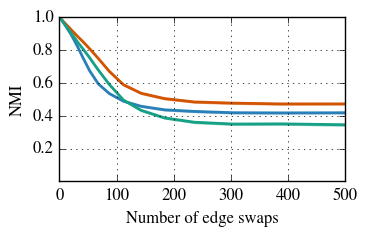

In [811]:
plt.figure(None, frameon=False)

confidence_intervals(X, Y0snM, "#2980b9", label="Adjacent layers linked")
confidence_intervals(X, Y1snM, c="#d35400", label="All layers linked")
confidence_intervals(X, Y2snM, c="#16a085", label="Divergence prop. links")
#confidence_intervals(X, Ynn, c="#2c3e50", label="Random")
#scatter_mean(X, Ynn, c="#2c3e50", label="Baseline")

# Y2nn_last = np.array(Y2nn)[:, -1]
# plt.plot(X[0], [np.mean(Y2nn_last)] * (len(X[0])), c="#2c3e50", ls="--", lw=2.5, label="Baseline (random)")
# # low, upp = st.t.interval(0.99, Y2nn_last.shape[0]-1, loc=np.mean(Y2nn_last), scale=st.sem(Y2nn_last))
# # plt.fill_between(X[0], low, upp, color="k", alpha=0.5)

plt.xticks(fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Number of edge swaps", fontsize=12)
plt.ylabel("NMI", fontsize=12)

plt.ylim(0.0, 1.0)
plt.xlim(0.0, 500)
plt.grid()
plt.tight_layout(pad=0)
plt.savefig("figures/NMI_vs_num_edgeswaps.png")
plt.savefig("figures/NMI_vs_num_edgeswaps.pdf")
plt.show()

#### As function of increasing number of noise layers

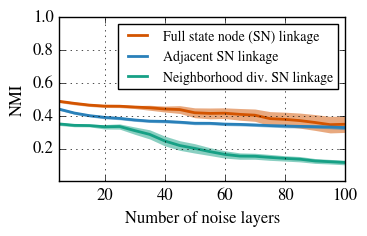

In [803]:
plt.figure(None, frameon=False)

confidence_intervals(X1, Y1snM1, c="#d35400", label="Full state node (SN) linkage")
confidence_intervals(X1, Y0snM1, "#2980b9", label="Adjacent SN linkage")
confidence_intervals(X1, Y2snM1, c="#16a085", label="Neighborhood div. SN linkage")
#scatter_mean(X1, Y2nn1, "#2c3e50", label="Baseline")

plt.xticks(fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Number of noise layers", fontsize=12)
plt.ylabel("NMI", fontsize=12)

plt.ylim(0.0, 1.0)
plt.xlim(5.0, 100)
plt.grid()
plt.legend()
plt.tight_layout(pad=0)
plt.savefig("figures/NMI_vs_N_noise.png")
plt.savefig("figures/NMI_vs_N_noise.pdf")
plt.show()

## Simulate NMI between noise layers for increasing number of edge swaps

In [ ]:
N_signal, N_noise = 1, 10

G = gen_G()

Ynn = []
for _ in range(100):
    x = []
    ynn = []

    for num_swaps in sorted(set([int(num_swaps) for num_swaps in np.logspace(0.1, np.log10(500), 25, base=10)])):

        temporal_network, signal_layers = temporal_network_with_signal_layer(G, N_signal, N_noise, num_swaps)

        _, layer_commu_pred_js = Infomap(
            temporal_network,
            'output/',
            '-i',
            'multiplex',
            '--multiplex-js-relax-rate', '0.25',
            '--overlapping',
            '--expanded',
            '--clu',
            '--pajek',
            '--two-level',
            '-z'
        )

        noise_layers = list(set(range(N_signal+N_noise)) - set(signal_layers))
        ynn.append(np.mean([
             normalized_mutual_info_score(
                np.random.randint(len(layer_commu_pred_js[l1]), size=len(G.nodes())),
                np.random.randint(len(layer_commu_pred_js[l2]), size=len(G.nodes()))
            )
            for l1 in noise_layers
            for l2 in noise_layers
            if l2 > l1
        ]))
        x.append(num_swaps)

        print num_swaps, 
        
    Ynn.append(ynn)

1 2 3 4 5 7 9 11 15 19 25 32 41 53 68 87 112 143 184 236 303 389 499 1 2 3 4 5 7 9 11 15 19 25 

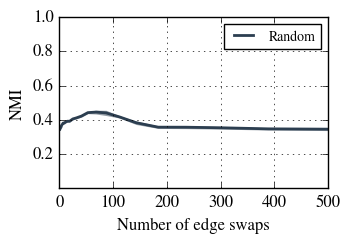

In [805]:
plt.figure(None, frameon=False)

confidence_intervals(X, Ynn, c="#2c3e50", label="Random")

plt.xticks(fontsize=12)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], fontsize=12)

plt.xlabel("Number of edge swaps", fontsize=12)
plt.ylabel("NMI", fontsize=12)

plt.ylim(0.0, 1.0)
plt.grid()
plt.legend()
#plt.savefig()
plt.show()

## Simulate recall vs. reccurency in noisy temporal networks

In [140]:
def gen_G_clustered(N=100, K=3, P=1, cut_nodes=15):
    G = nx.powerlaw_cluster_graph(N + cut_nodes, K, P)
    for n, k in sorted(G.degree().items(), key=lambda k: k[1], reverse=True)[:cut_nodes]:
        G.remove_node(n)
    for n, k in G.degree().items():
        if k == 0: G.remove_node(n)
    return G

def gen_G_watts_strogatz(N=100, K=4, P=0.2):
    G = nx.watts_strogatz_graph(N, K, P)
    return G
def gen_G_erdos_renyi(N=100, P=0.05):
    G = nx.erdos_renyi_graph(N, P)
    return G

In [4]:
G = gen_G_watts_strogatz(P=1)
#G = gen_G_erdos_renyi()
#G = gen_G_clustered()

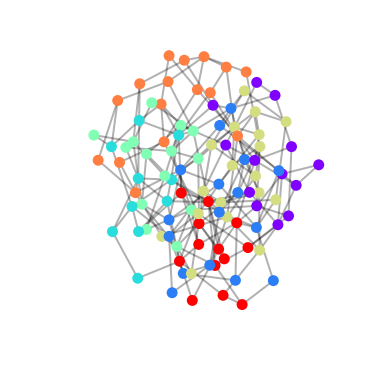

In [147]:
plt.figure(None, (6, 6))
ulf.draw(G, community_detection=True)
plt.show()

In [218]:
def unittest(f):    
    def _test(G, pairs):
        for ni, nj in pairs:
            if ni not in G.neighbors(nj) or nj not in G.neighbors(ni):
                raise Exception("Unittest failed")
    @wraps(f)
    def wrapper(*args, **kwargs):
        _, communities = args
        G = f(*args, **kwargs)
        pairs = [(ni, nj) for i, ni in enumerate(communities) for j, nj in enumerate(communities) if j > i]
        _test(G, pairs)
        return G
    return wrapper

@unittest
def plant_community_in_graph(G, community=[]):
    
    if community == []:
        raise Exception("Specify list of nodes to connect in 'community' argument")
    
    G_copy = G.copy()
    
    for i, ni in enumerate(community):
        for j, nj in enumerate(community):
        
            if i >= j:
                continue
            
            print "Connecting %d and %d" % (ni, nj)
            if ni in G_copy.neighbors(nj):
                print "-- ni", "and", nj, "are already neighbors"
                continue
            
            for nt in set(G_copy.neighbors_iter(nj)) - set(community):
                swappable = (set(G_copy.neighbors(ni)) - set(G_copy.neighbors(nt))) - set(community)
                print "\tfound %d swappable neighbors for %d" % (len(swappable), nj)
                if len(swappable) > 0:
                    nu = choice(list(swappable))
                    print "\t%d has a link to %d. trading that for a connection to %d" % (nt, nj, nu)
                    break
            else:
                raise Exception("No possible swaps for node %d and %d" % (ni, nj))
            
            G_copy.remove_edge(nj, nt)
            G_copy.add_edge(nj, ni)
            
            G_copy.remove_edge(ni, nu)
            G_copy.add_edge(nt, nu)

    return G_copy

In [219]:
G = gen_G_watts_strogatz(N=100, K=10, P=1)
G_planted = plant_community_in_graph(G, G.nodes()[:9])

Connecting 0 and 1
	found 9 swappable neighbors for 1
	65 has a link to 1. trading that for a connection to 31
Connecting 0 and 2
	found 8 swappable neighbors for 2
	34 has a link to 2. trading that for a connection to 91
Connecting 0 and 3
	found 6 swappable neighbors for 3
	67 has a link to 3. trading that for a connection to 79
Connecting 0 and 4
-- ni and 4 are already neighbors
Connecting 0 and 5
	found 5 swappable neighbors for 5
	71 has a link to 5. trading that for a connection to 9
Connecting 0 and 6
	found 5 swappable neighbors for 6
	96 has a link to 6. trading that for a connection to 13
Connecting 0 and 7
	found 4 swappable neighbors for 7
	98 has a link to 7. trading that for a connection to 64
Connecting 0 and 8
	found 3 swappable neighbors for 8
	34 has a link to 8. trading that for a connection to 11
Connecting 1 and 2
	found 8 swappable neighbors for 2
	71 has a link to 2. trading that for a connection to 59
Connecting 1 and 3
	found 7 swappable neighbors for 3
	77 ha

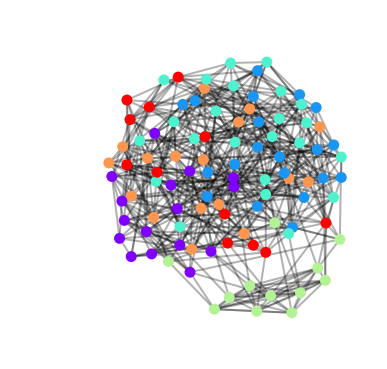

In [220]:
plt.figure(None, (6, 6))
ulf.draw(G_planted, community_detection=True)
plt.show()

In [347]:
G = nx.relaxed_caveman_graph(10, 5, 0.0)
partition = community.best_partition(G)
G = independent_edge_swaps(G, 100)
#G = nx.double_edge_swap(G, 10)

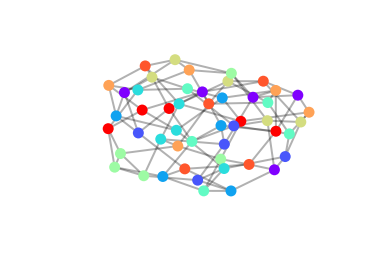

In [348]:
ulf.draw(G, partition=partition)

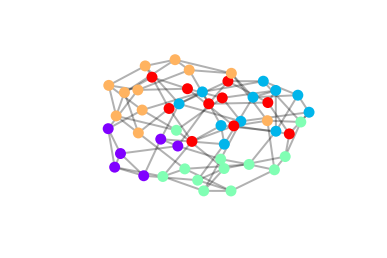

In [349]:
ulf.draw(G, partition=True)

In [ ]:
def unittest(f):    
    from functools import wraps
    @wraps(f)
    def wrapper(*args, **kwargs):
        # Test something with the args, kwargs and the wrapped function f
        return f(*args, **kwargs)
    return wrapper

@unittest
def f(arg1, arg2, kwarg1=1, kwarg2=2):
    # A function that does something
    return G_copy